In [1]:
import pandas as pd
import ktrain

/home/j/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in data
train_df = pd.read_csv('/home/j/Documents/Projects/social-media-combat-detection/data/train.csv')

train_df = train_df[(train_df['annotation'] == '1') | (train_df['annotation'] == '0')]

train_df['annotation'] = train_df['annotation'].astype(int)

train_df.head()

,idx,msg_txt,annotation
1,910,:face_with_symbols_on_mouth:Occupants plan t...,0
2,2063,"Ukraine is preparing for a counterattack, De...",1
3,1018,Information on the state of restoration of c...,0
4,2378,White House statement Russia will not succee...,0
6,1776,:enraged_face: Enemy's TG channels are sprea...,0


In [3]:
test_df = pd.read_csv('/home/j/Documents/Projects/social-media-combat-detection/data/test.csv')

test_df = test_df[(test_df['annotation'] == '1') | (test_df['annotation'] == '0')]

test_df['annotation'] = test_df['annotation'].astype(int)

test_df.head()

,idx,msg_txt,annotation
0,2983,DIU Russians modernized X-22 and Oniks missi...,0
1,1612,Wagner currently controls 4.8 thousand km2 o...,0
2,35,At the positions of the artillery of the 32n...,0
4,2332,We receive reports that there are power outa...,0
5,330,The law on electronic subpoenas equates Russ...,0


In [4]:
combat  = train_df[train_df['annotation']==1.0]

not_combat = train_df[train_df['annotation']==0.0].sample(len(combat))

In [5]:
data_sample = pd.concat([combat, not_combat])

In [6]:
data_sample.head()

,idx,msg_txt,annotation
2,2063,"Ukraine is preparing for a counterattack, De...",1
9,94,Kyiv region repels drone attacks for the sec...,1
14,704,"As of this moment, about 10 air targets have...",1
15,793,"On April 24, six Shahed-136/131 strike aircr...",1
31,891,:face_with_symbols_on_mouth: All night the R...,1


In [7]:
data_sample['annotation'].describe()

count    1420.000000
mean        0.500000
std         0.500176
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: annotation, dtype: float64

## Modeling

Next, I'll load in a pre-trained transformer model. For now, I will use 'distilbert'.

In [26]:
train, val, preprocess = ktrain.text.texts_from_df(
    data_sample,
    text_column = 'msg_txt',
    label_columns = ['annotation'],
    val_df = None,
    max_features = 100000,
    maxlen = 128,
    val_pct = 0.1,
    ngram_range = 5,
    preprocess_mode = 'bert',
    verbose = 1
)

['not_annotation', 'annotation']
      not_annotation  annotation
923              1.0         0.0
2273             0.0         1.0
98               1.0         0.0
1921             1.0         0.0
2427             0.0         1.0
['not_annotation', 'annotation']
      not_annotation  annotation
1194             0.0         1.0
2422             1.0         0.0
417              0.0         1.0
2770             1.0         0.0
1440             1.0         0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [27]:
model = learner.model#ktrain.text.text_classifier('bert', train_data=train, preproc=preprocess)
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=32)

In [20]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...


/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/6


ResourceExhaustedError: Graph execution error:

Detected at node model_3/Encoder-12-MultiHeadSelfAttention-Dropout/dropout/random_uniform/RandomUniform defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/j/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_5115/234791580.py", line 1, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/ktrain/core.py", line 629, in lr_find

  File "/home/j/.local/lib/python3.10/site-packages/ktrain/lroptimize/lrfinder.py", line 141, in find

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/layers/regularization/dropout.py", line 120, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/layers/regularization/dropout.py", line 116, in dropped_inputs

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/backend.py", line 2172, in dropout

OOM when allocating tensor with shape[32,128,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/Encoder-12-MultiHeadSelfAttention-Dropout/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_73524]

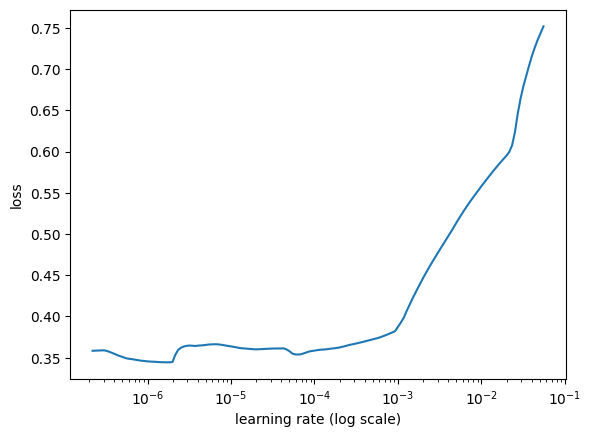

In [72]:
learner.lr_plot()

In [28]:
history=learner.autofit(lr=1e-4, epochs=100, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/100
40/40 [==============================] - 14s 345ms/step - loss: 0.1115 - accuracy: 0.9640 - val_loss: 0.0673 - val_accuracy: 0.9930
Epoch 2/100
40/40 [==============================] - 14s 343ms/step - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.0440 - val_accuracy: 0.9789
Epoch 3/100
40/40 [==============================] - 13s 336ms/step - loss: 0.0249 - accuracy: 0.9930 - val_loss: 0.0221 - val_accuracy: 0.9859
Epoch 4/100
40/40 [==============================] - 14s 338ms/step - loss: 0.0590 - accuracy: 0.9773 - val_loss: 0.1279 - val_accuracy: 0.9648
Epoch 4: early stopping
Weights from best epoch have been loaded into model.


In [29]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [32]:
validation = learner.validate(val_data=val, print_report=True)

5/5 [==============================] - 0s 85ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        64
           1       0.97      1.00      0.99        78

    accuracy                           0.99       142
   macro avg       0.99      0.98      0.99       142
weighted avg       0.99      0.99      0.99       142



In [38]:
learner.save_predictor('bert-model')

AttributeError: 'BERTTextClassLearner' object has no attribute 'save_predictor'

In [34]:
import pickle
with open('../models/bert.pickle', 'wb') as handle:
    pickle.dump(predictor, handle, protocol=pickle.HIGHEST_PROTOCOL)